In [92]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize
from qiskit.extensions import ZGate
# Import isprime function from sympy library
from sympy.ntheory.primetest import isprime

In [77]:
def quantum_adder(n_bits:int):
    '''
    This function creates a quantum circuit that adds two n-bit binary numbers.
    
    Parameters:
    ----------
    n_bits: int
        The number of bits in the binary numbers.
    
    Returns:
    -------
    qc: QuantumCircuit
        The quantum circuit that adds two n-bit binary numbers.
    '''
    q_r_numberA = QuantumRegister(n_bits, name='A')
    q_r_numberB = QuantumRegister(n_bits, name='B')
    q_r_carry = QuantumRegister(n_bits, name='Carry')

    qc = QuantumCircuit(q_r_numberA, q_r_numberB, q_r_carry, name='Quantum_Adder')

    # Add both registers
    for i in range(n_bits):
        qc.ccx(q_r_numberA[i], q_r_numberB[i], q_r_carry[i])
        qc.cx(q_r_numberA[i], q_r_numberB[i])
        if i > 0:
            qc.ccx(q_r_numberB[i], q_r_carry[i-1], q_r_carry[i])
            qc.cx(q_r_carry[i-1], q_r_numberB[i])
    
    # The result is encoded in the last carry qubit (the most significant bit) and the B register

    return qc

In [90]:
def find_the_primes_numbers(number_1:int, list_primes:list[int]):
    '''
    This function finds the two prime numbers that make up the number_1. (Goldbach's conjecture)

    Parameters
    ----------
    number_1 : int
        The number to be decomposed into prime numbers.
    list_primes : list[int]
        List of prime numbers.
    
    Returns
    -------
    list[int]
        List of two prime numbers that make up the number_1.
    '''

    # Identify the number of qubits needed to represent the largest number in the list of prime numbers.
    max_number = np.max(list_primes)
    num_qubits_max_number = int(np.ceil( np.log2( max_number ) ))

    # Compute the initial state as an uniform superposition of all possible prime numbers contained in the list.
    input_state = np.zeros( 2**num_qubits_max_number )
    for prime in list_primes:
        input_state[prime] = 1
    input_state /= np.sqrt( len(list_primes) )

    q_r_numberA = QuantumRegister(num_qubits_max_number, name='A')
    q_r_numberB = QuantumRegister(num_qubits_max_number, name='B')
    q_r_carry = QuantumRegister(num_qubits_max_number, name='Carry')

    c_r_number = ClassicalRegister(num_qubits_max_number * 2 + 1, name='Result')

    qc = QuantumCircuit(q_r_numberA, q_r_numberB, q_r_carry, c_r_number)

    input_primes_state = Initialize(input_state).gates_to_uncompute()

    # ------------------------------------------------------------ #
    # ---------------------- Operator A -------------------------- #
    # ------------------------------------------------------------ #
    def A(input_state, n_qubits, inverse=False):
        q_r_numberA = QuantumRegister(n_qubits, name='A')
        q_r_numberB = QuantumRegister(n_qubits, name='B')
        q_r_carry = QuantumRegister(n_qubits, name='Carry')

        qc = QuantumCircuit(q_r_numberA, q_r_numberB, q_r_carry)

        if inverse:
            qc.append(quantum_adder(n_qubits).inverse(), q_r_numberA[:] + q_r_numberB[:] + q_r_carry[:])
            qc.append(input_state, q_r_numberA[:])
            qc.append(input_state, q_r_numberB[:])

            qc.name = '$A^\dagger$'

            return qc

        qc.append(input_state.inverse(), q_r_numberA[:])
        qc.append(input_state.inverse(), q_r_numberB[:])
        qc.append(quantum_adder(n_qubits), q_r_numberA[:] + q_r_numberB[:] + q_r_carry[:])

        qc.name = '$A$' 
        return qc

    # ------------------------------------------------------------ #
    # Grover's algorithm
    # ------------------------------------------------------------ #

    # Oracle

    def S_f(number, num_qubits):
        q_r = QuantumRegister(num_qubits, name='q_r')
        qc = QuantumCircuit(q_r, name='$S_f$')
        
        bit_string = np.binary_repr(number, width=num_qubits)

        if bit_string[0] == '0':
            qc.x(q_r[-1])

        # Apply the Control Z gate to the last index
        qc.append(ZGate().control(len(bit_string)-1, ctrl_state=bit_string[1:]), q_r)

        if bit_string[0] == '0':
            qc.x(q_r[-1])

        return qc        

    # ------------------------------------------------------------ #

    qc.append(A(input_primes_state, num_qubits_max_number), q_r_numberA[:] + q_r_numberB[:] + q_r_carry[:])
    q_r_number = q_r_numberB[:] + [q_r_carry[-1]]

    qc.append(S_f(number_1, num_qubits_max_number + 1), q_r_number)
    qc.append(A(input_primes_state, num_qubits_max_number, inverse=True), q_r_numberA[:] + q_r_numberB[:] + q_r_carry[:])
    [qc.x(q) for q in q_r_number]
    qc.append(ZGate().control(len(q_r_number)-1), q_r_number)
    [qc.x(q) for q in q_r_number]
    qc.append(A(input_primes_state, num_qubits_max_number), q_r_numberA[:] + q_r_numberB[:] + q_r_carry[:])


    qc = qc.decompose(gates_to_decompose=['$S_f$'])

    # Measure the result
    qc.measure(q_r_numberA, c_r_number[:num_qubits_max_number])
    qc.measure(q_r_number, c_r_number[num_qubits_max_number:])

    # qc.measure(q_r_carry[-1], c_r_number[-1])

    # Execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    result = job.result()
    counts = result.get_counts()

    # Histogram
    display(plot_histogram(counts))

    # Find the most frequent result
    values = list(counts.values())
    # All keys where the values are more than 80
    keys = [key for key, value in counts.items() if value > 80]
    
    results = [(key[:num_qubits_max_number + 1], key[num_qubits_max_number + 1:]) for key in keys]
    print(results)

    return list(map( lambda x: (int(x[0], 2), int(x[1], 2)), results))

[1, 2, 3, 5, 7, 11, 13, 17, 19]


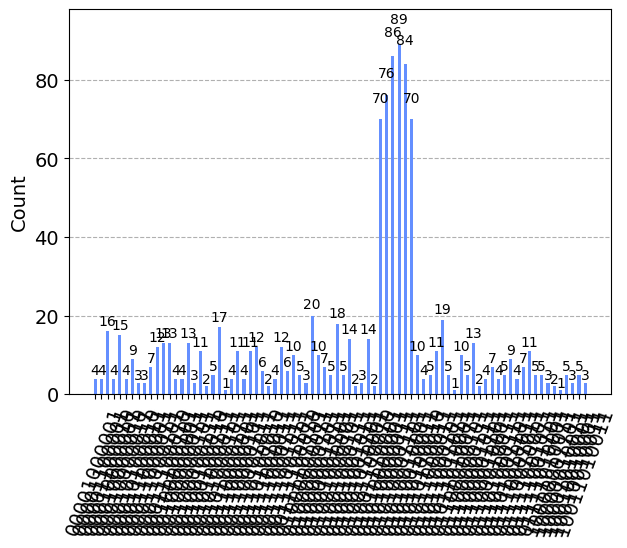

[('010100', '10001'), ('010100', '00111'), ('010100', '01101')]


[(20, 17), (20, 7), (20, 13)]

In [99]:
number = 20
list_primes = [1] + [n if isprime(n) else None for n in range(2, number)]
list_primes = [n for n in list_primes if n is not None]
print(list_primes)
find_the_primes_numbers(number, list_primes)